In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

In [24]:
class Theoretical_Ranges:
    def __init__(self, min_max_path: str, input_names: list[str], must_be_zero: list[str],
                 scaling_factor: float=1e-12, sheet_name:str = 'icranges'):
        self.name = os.path.splitext(os.path.basename(min_max_path))[0]
        self.df_ranges = pd.read_excel(min_max_path, sheet_name=sheet_name)
        self.df_ranges['value'] = self.df_ranges['value'].astype(float)
        self.df_ranges.species = [s.upper() for s in self.df_ranges.species]
        self.scaling_factor = scaling_factor
        self.df_scaled_ranges = self.df_ranges.select_dtypes(include='number') * self.scaling_factor
        self.must_be_zero = must_be_zero
        self.input_names = input_names
        self.get_input_data(input_names)
        self.bounds = self.get_bounds()
        self.gen_lookuptable()

    def get_input_data(self, input_names: list[str]) -> None:
        self.inputs = {}
        for i in input_names:
            self.inputs[i] = 0.0
        self.inputs["REF"] = 1.0
        self.inputs["Insulin"] = 1e-10

        self.input_data = pd.DataFrame([
            {'species': species, 'minconc': value*1e+12, 'value': value*1e+12, 'maxconc': value*1e+12}
            for species, value in self.inputs.items()])

    def gen_lookuptable(self) -> None:
        self.lut = pd.concat([self.df_ranges, self.input_data], ignore_index=True)    # look-up-table
        self.lut['species'] = self.lut['species'].str.upper()
        print(f"LUT was created successfully. Its dimensions are: {self.lut.shape}")

    def get_bounds(self) -> dict[str, tuple[float, float]]:
        bounds = dict()
        for index, row in self.df_ranges.iterrows():
            if row.value < 0.1:
                lb = 1e-14
                ub = 1e-13
            else:
                lb = (row.value/2)*1e-12
                ub = (row.value*1.5)*1e-12
            bounds[row.species.upper()] = [lb, ub]
        print(bounds['TBID'])
        for index, row in self.input_data.iterrows():
            if row.species.upper() not in bounds.keys():
                bounds[row.species] = [row.minconc*1e-12, row.maxconc*1e-12]
        for m in self.must_be_zero:
            bounds[m.upper()] = [0, 0]
        return bounds


In [33]:
class Model_def:
    def __init__(self, model_name: str, input_species: list[str], # data_source: a pandas DataFrame
                 output_species: list[str], time_points: list[float],
                 species_rng: Theoretical_Ranges, exp_vals: list[float],
                 stress: tuple[str: float]=('RAPEC', 5e-5)): # dict[stress_species: init_cc] = [rap extracell.: [mol/cm^3]]
        self.rng = species_rng
        self.model_name = model_name
        self.input_species = input_species
        self.output_species = output_species
        self.time_points = time_points
        self.exp_vals = exp_vals
        self.stress = stress
        self.check_compatibility()

    def check_compatibility(self) -> None:
        for s in self.output_species:
            if s not in self.input_species:
                RuntimeError('Output species not found in input')
        for s in self.input_species:
            if s.upper() not in self.rng.bounds.keys():
                self.rng.bounds[s] = [0, 0]
                print(f"Creating new entry for {s}\n")


In [ ]:
class Simulation:
    def __init__(self, species_range: Theoretical_Ranges, experiment: Experiment, max_digit = 4):
        self.species_range = species_range
        self.experiment = experiment
        self.maxdigit = max_digit

    def create_xml_files(self, output_xmls_path: str, num_of_xmls: int, xml_template_path: str) -> None:
        if not os.path.exists(output_xmls_path):
            os.makedirs(output_xmls_path)
        self.num_of_xmls = num_of_xmls
        env = jinja2.Environment(loader=jinja2.FileSystemLoader(os.path.dirname(xml_template_path)))
        self.template = env.get_template(os.path.basename(xml_template_path))

        for i in range(1, num_of_xmls+1):
            np.random.seed(i)
            self.random_ics = self.get_random_ics()
            self.experiment.quantitated_exp_data(ics=self.random_ics)
            self.make_xml_output(i, output_xmls_path)

    def get_random_ics(self) -> dict[str, float]:
        random_ics = {}
        #random_ics = {s: np.random.uniform(*self.species_range.bounds[s]) for s in self.species_range.bounds}
        inp_upper = [s.upper() for s in self.experiment.input_species]
        for key in self.experiment.input_species:
            if self.species_range.bounds[key][0] == 0 and self.species_range.bounds[key][1] == 0:
                random_ics[key] = 1e-14
            else:
                random_ics[key] = np.random.uniform(*self.species_range.bounds[key])
        random_ics[self.experiment.stress.keys()[0]] = self.experiment.stresses
        random_ics["REF"] = 1.0
        return random_ics

    def make_xml_output(self, file_index: int, output_xmls_path: str) -> None:
        dataPoints = [self.compileDataRow(row.values) for _, row in self.experiment.quant_data.iterrows()]
        output = self.template.render(ics=self.random_ics, variables=self.experiment.species, dataPoints=dataPoints, bib=self.experiment.bibtex)
        padded_number = str(file_index).zfill(self.maxdigit)
        filename = f"stressful_life_{padded_number}.xml"
        with open(os.path.join(output_xmls_path, filename), 'w') as f:
            f.write(output)

    def compileDataRow(self, dataPoints):
        meas = "".join(f"<{v}>{{:.4e}}</{v}>" for v in self.experiment.experiment_data.columns)
        return f"<dataPoint>{meas.format(*dataPoints)}</dataPoint>"

    def generate_opp_content(self, xml_folder: str, name: str, mech_file: str,
                             yaml_file: str, time_limit: int, thread_limit: int,
                             settings_tag: str, solver: str) -> str:

      # Create MECHMOD section
      mechmod = f"""MECHMOD
      USE_NAME         BCRN6
      MECH_FILE        {mech_file}
      COMPILE_cantera  {yaml_file}
      END
      """

      # Create MECHTEST section
      mechtest = f"""MECHTEST
      MECHANISM  BCRN6
      TIME_LIMIT {time_limit}
      THREAD_LIMIT {thread_limit}
      SETTINGS_TAG {settings_tag}
      FALLBACK_TO_DEFAULT_SETTINGS

      SOLVER {solver}
      SAVE_STATES      CSV
      """

      # Add each XML file name
      for xml_idx in range(1, self.num_of_xmls+1):
          padded_number = str(xml_idx).zfill(self.maxdigit)
          mechtest += f"      NAME {xml_folder}/stressful_life_{padded_number}.xml\n"

      mechtest += "END\n"

      return mechmod + "\n" + mechtest

    def gen_opp(self, output_dir, sheet_name, opp_output_dir, mech_file: str = "7_Krisztian/mech/BCRN6.inp",
                yaml_file: str = "7_Krisztian/mech/BCRN6.yaml", time_limit: int = 50, thread_limit: int = 32,
                settings_tag: str = "systems_biology", solver: str = "cantera"):
        date = datetime.datetime.now()
        opp_content = self.generate_opp_content(output_dir, sheet_name, mech_file, yaml_file, time_limit,
                                                thread_limit, settings_tag, solver)  # Create .opp file content
        opp_filename = f"{date.year}{date.month}{date.day}_BCRN_{self.experiment.bibtex['author'].split()[0][:-1]}_{sheet_name}.opp" # Define output .opp file path
        with open(os.path.join(opp_output_dir, opp_filename), "w") as f:
            f.write(opp_content)


NameError: name 'Experiment' is not defined

In [31]:
alma = {'a': 'korte', 'b': 'barack', 'e': 'eper'}
alma.keys()[0]

TypeError: 'dict_keys' object is not subscriptable

In [3]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/szupernikusz/TDK/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [4]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 input_mech: str = 'BCRN6',
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }

        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)
            self.get_finer_df()

        if (self.job_folder / f"mechTestResults_{input_mech}.csv").exists():
            self.all_sheets_dP = pd.read_csv(self.job_folder / f"mechTestResults_{input_mech}.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'])
            self.get_coarse_df(all_sheets_dP=self.all_sheets_dP)

    def get_finer_df(self): # states_stac_0002_proper_time_p1_Rap_transz
        self.fine_time_df_dict: dic[str: pd.DataFrame()] = {}
        for k, v in self.all_data.items():
            xml_name = k.split('states_')[1].split('_p1')[0]
            v_df = v.drop(['T[K]', 'p[Pa]'], axis=1)
            aa = ['t[s]'] + [a.split('x_')[1] for a in v_df.columns[1:]]
            v_df.columns = aa
            self.fine_time_df_dict[xml_name] = v_df

    def get_coarse_df(self, all_sheets_dP):
        self.orig_time_sim_df: dict[str: pd.DataFrame()] = {}
        self.orig_time_exp_df: dict[str: pd.DataFrame()] = {}
        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        for idx, row in all_sheets_dP.iterrows():
            xml_name = row.xml
            sim_val = row.sim_val
            exp_val = row.dP_val

            if row.species == species:
                time_point = time_point + 1
            else:
                species = row.species
                time_point = 1
            
            if xml_name not in self.orig_time_sim_df.keys():
                self.orig_time_sim_df[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.orig_time_sim_df[xml_name].loc[time_point, species] = sim_val
            if xml_name not in self.orig_time_exp_df.keys():
                self.orig_time_exp_df[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.orig_time_exp_df[xml_name].loc[time_point, species] = exp_val
            

In [5]:
mech = OptimaMechtest("20250530_RAP2_proper_time.opp", 'Rap_transz')

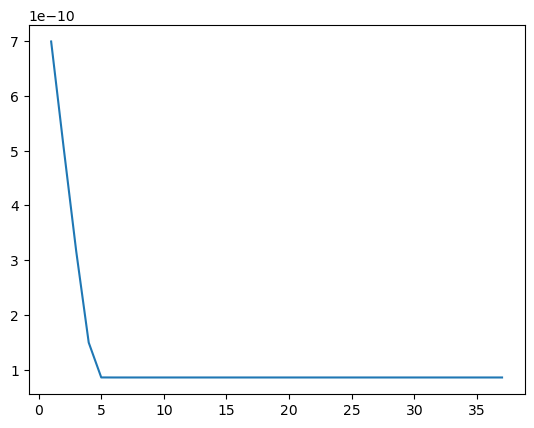

In [22]:
plt.plot(mech.orig_time_sim_df['stac_0002_proper_time'])